# Import

In [1]:
import tensorflow as tf
import PIL
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
from tensorflow.keras.applications import mobilenet as _mobilenet
import random
import os
import numpy as np
from PIL import Image
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from IPython.display import Image as iImage
from IPython.display import display
import math
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# SOM functions

In [2]:
def normalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    normalised_p = (p-min_d)/(max_d - min_d)
    return normalised_p

def denormalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    denormalised_p = p * (max_d - min_d) + min_d
    return denormalised_p
def find_BMU(SOM, x):
    somShape = SOM.shape
    simSOM = SOM.reshape((-1, len(x)))
    cos_sims = cosine_similarity([x], simSOM).reshape((somShape[0], somShape[1]))
    return np.unravel_index(np.argmax(cos_sims, axis=None), cos_sims.shape)


# def find_BMU(SOM,x):
#     somShape = SOM.shape
#     simSOM = SOM.reshape((-1, len(x)))
#     cos_sims = cosine_similarity([x], simSOM).reshape(somShape[:2])
#     return np.unravel_index(np.argmax(cos_sims, axis=None), cos_sims.shape)
def find_BMU_2(SOM,x):
    somShape = SOM.shape
    simSOM = SOM.reshape((-1, len(x)))
    cos_sims = cosine_similarity([x], simSOM).reshape(somShape[:2])
    return np.unravel_index(np.argpartition(cos_sims, -2, axis=None)[-2], cos_sims.shape)

# Update the weights of the SOM cells when given a single training example
# and the model parameters along with BMU coordinates as a tuple
def update_weights(SOM, train_ex, learn_rate, radius_sq,
                   BMU_coord, step=3):
    g, h = BMU_coord
    #if radius is close to zero then only BMU is changed
    if radius_sq < 1e-3:
        SOM[g,h,:] += learn_rate * (train_ex - SOM[g,h,:])
        return SOM
    # Change all cells in a small neighborhood of BMU
    for i in range(max(0, g-step), min(SOM.shape[0], g+step)):
        for j in range(max(0, h-step), min(SOM.shape[1], h+step)):
            dist_sq = np.square(i - g) + np.square(j - h)
            dist_func = np.exp(-dist_sq / 2 / radius_sq)
            SOM[i,j,:] += learn_rate * dist_func * (train_ex - SOM[i,j,:])
    return SOM

# Main routine for training an SOM. It requires an initialized SOM grid
# or a partially trained grid as parameter
def train_SOM(SOM, train_data, learn_rate = .1, radius_sq = 1,
             lr_decay = .1, radius_decay = .1, epochs = 10):
    learn_rate_0 = learn_rate
    radius_0 = radius_sq
    for epoch in np.arange(0, epochs):
        rand.shuffle(train_data)
        for train_ex in train_data:
            g, h = find_BMU(SOM, train_ex)
            SOM = update_weights(SOM, train_ex,
                                 learn_rate, radius_sq, (g,h))
        # Update learning rate and radius
        learn_rate = learn_rate_0 * np.exp(-epoch * lr_decay)
        radius_sq = radius_0 * np.exp(-epoch * radius_decay)
    return SOM

import scipy
def calculateQE(SOM,data):
    sumSqDist = 0
    for d in data:
        g,h = find_BMU(SOM, d)
        v1 = SOM[g,h]
        v2 = d
        sumSqDist += scipy.spatial.distance.cdist([v1],[v2],'sqeuclidean')[0][0]
    QE = sumSqDist/len(data)
    return QE

def calculateTE(SOM,data):
    failed = 0
    for d in data:
        g1,h1 = find_BMU(SOM,d)
        g2,h2 = find_BMU_2(SOM,d)
        dist = scipy.spatial.distance.cityblock([g1,h1], [g2,h2])
        if dist>1:
            failed+=1
    return failed/len(data)

import sklearn
#这段代码实现了计算自组织映射（SOM）训练后的网络的U-矩阵（U-matrix）。U-矩阵是一种可视化工具，用于显示SOM中各单元之间的相似度
def euclidean(a, b):
    return np.linalg.norm(a-b)

def cosine(a,b):
    return cosine_similarity([a], [b])[0][0]


def u_matrix(lattice):
    """Builds a U-matrix on top of the trained lattice.

        Parameters
        ---
        lattice : list

            The SOM generated lattice

        Returns
        ---
        The lattice of the shape (R,C):

        R - number of rows; C - number of columns;
        """
    X, Y, Z = lattice.shape
    u_values = np.empty((X,Y), dtype=np.float64)

    for y in range(Y):
        for x in range(X):
            current = lattice[x,y]
            dist = 0
            num_neigh = 0
            # left
            if x-1 >= 0:
                #middle
                vec = lattice[x-1,y]
                dist += cosine(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #sup
                    vec = lattice[x-1, y-1]
                    dist += cosine(current, vec)
                    num_neigh += 1
                if y + 1 < Y:
                    # down
                    vec = lattice[x-1,y+1]
                    dist += cosine(current, vec)
                    num_neigh += 1
            # middle
            if y - 1 >= 0:
                # up
                vec = lattice[x,y-1]
                dist += cosine(current, vec)
                num_neigh += 1
            # down
            if y + 1 < Y:
                vec = lattice[x,y+1]
                dist += cosine(current, vec)
                num_neigh += 1
            # right
            if x + 1 < X:
                # middle
                vec = lattice[x+1,y]
                dist += cosine(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #up
                    vec = lattice[x+1,y-1]
                    dist += cosine(current, vec)
                    num_neigh += 1
                if y + 1 < lattice.shape[1]:
                    # down
                    vec = lattice[x+1,y+1]
                    dist += cosine(current, vec)
                    num_neigh += 1
            u_values[x,y] = dist / num_neigh
    u_values = (u_values - 1) * -1
    return u_values

def activate(train_data, SOM, p):
    normalP = normalise(train_data, p)
    activatedSOM = np.array([[cosine_similarity([normalP], [c])[0][0] for c in r] for r in SOM])
    normalisedActivatedSOM = normalise(activatedSOM, activatedSOM)
    #activatedSOM = (normalisedActivatedSOM -1)*(-1)
    return activatedSOM

# Image process functions

In [21]:
def img_reshape(img):
    img = Image.open('D:/sp/matched frames/'+img).convert('RGB')
    img = img.resize((100,100))
    img = np.asarray(img)
    return img
def processImage(imagePath, model):
    im = load_image(imagePath)
    f = model.predict(im)[0]
    return f
def load_image(img_file, target_size=(224,224)):
    X = np.zeros((1, *target_size, 3))
    X[0, ] = np.asarray(tf.keras.preprocessing.image.load_img(
        img_file,
        target_size=target_size)
    )
    X = tf.keras.applications.mobilenet.preprocess_input(X)
    return X

# Search functions

In [32]:
def get_neighbors(coord, max_i, max_j, radius=1):
    """ Get neighbors in a grid within the specified radius around a coordinate.
        Includes the original coordinate. """
    neighbors = []
    for i in range(max(0, coord[0] - radius), min(max_i, coord[0] + radius + 1)):
        for j in range(max(0, coord[1] - radius), min(max_j, coord[1] + radius + 1)):
            neighbors.append((i, j))
    return neighbors


# Load and prepare

In [9]:
momaFiles = os.listdir(r"D:\sp\matched frames")
momaFiles = momaFiles[:300]
features = []
model = tf.keras.applications.mobilenet.MobileNet(
# The 3 is the three dimensions of the input: r,g,b.
  input_shape=(224, 224, 3),
  include_top=False,
  pooling='avg'
)
for m in momaFiles:
    path = os.path.join(r"D:\sp\matched frames", m)
    f = processImage(path, model)
    features.append(f)
featureImagePairs = []
for i in range(len(features)):
    featureImage = {}
    featureImage['image'] = momaFiles[i]
    featureImage['feature'] = features[i]
    featureImagePairs.append(featureImage)

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


# Visualize

In [10]:
# Dimensions of the SOM grid
m = 8
n = 8
# Number of training examples
n_x = 300
rand = np.random.RandomState(0)
# Initialize the training data
train_data = features

# Normalised Training Data
n_train_data = normalise(train_data, train_data)

# Initialize the SOM randomly
SOM = rand.uniform(0, 1, (m, n, len(train_data[0])))

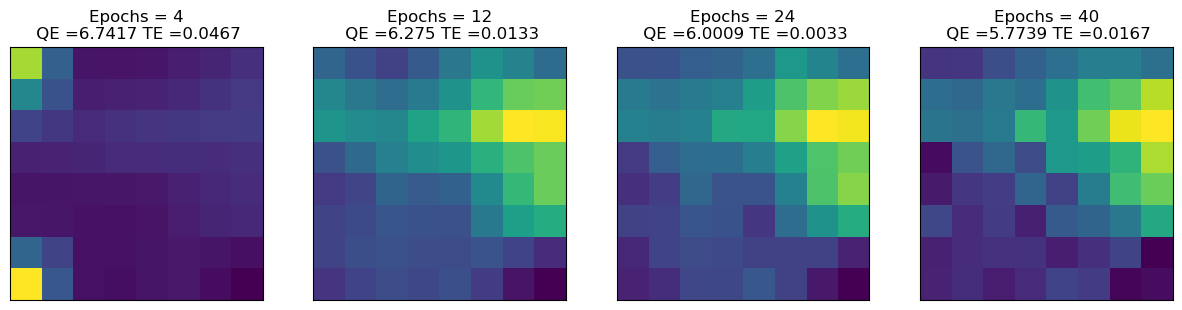

In [11]:
fig, ax = plt.subplots(
    nrows=1, ncols=4, figsize=(15, 3.5),
    subplot_kw=dict(xticks=[], yticks=[]))
total_epochs = 0
SOMS = []
for epochs, i in zip([4, 8, 12, 16], range(0,4)):
    total_epochs += epochs
    SOM = train_SOM(SOM, n_train_data, learn_rate = .1, radius_sq = 2, epochs = epochs)
    SOMS.append(SOM)
    QE = round(calculateQE(SOM, n_train_data), 4)
    TE = round(calculateTE(SOM, n_train_data), 4)

    ax[i].imshow(u_matrix(SOM))
    ax[i].title.set_text('Epochs = ' + str(total_epochs) + '\n QE =' + str(QE) + ' TE =' + str(TE))

In [14]:
SOM = SOMS[-1]
SOMimages = [[[] for _ in range(len(SOM[0]))] for _ in range(len(SOM))]

for fi in featureImagePairs:

    g, h = find_BMU(SOM, normalise(SOM, fi['feature']))
    SOMimages[g][h].append(fi)

imageGrid = []
for row in SOMimages:
    for cell in row:
        if len(cell) > 0:
            imageGrid.append(cell[0]['image']) 
        else:
            imageGrid.append('white.png')  

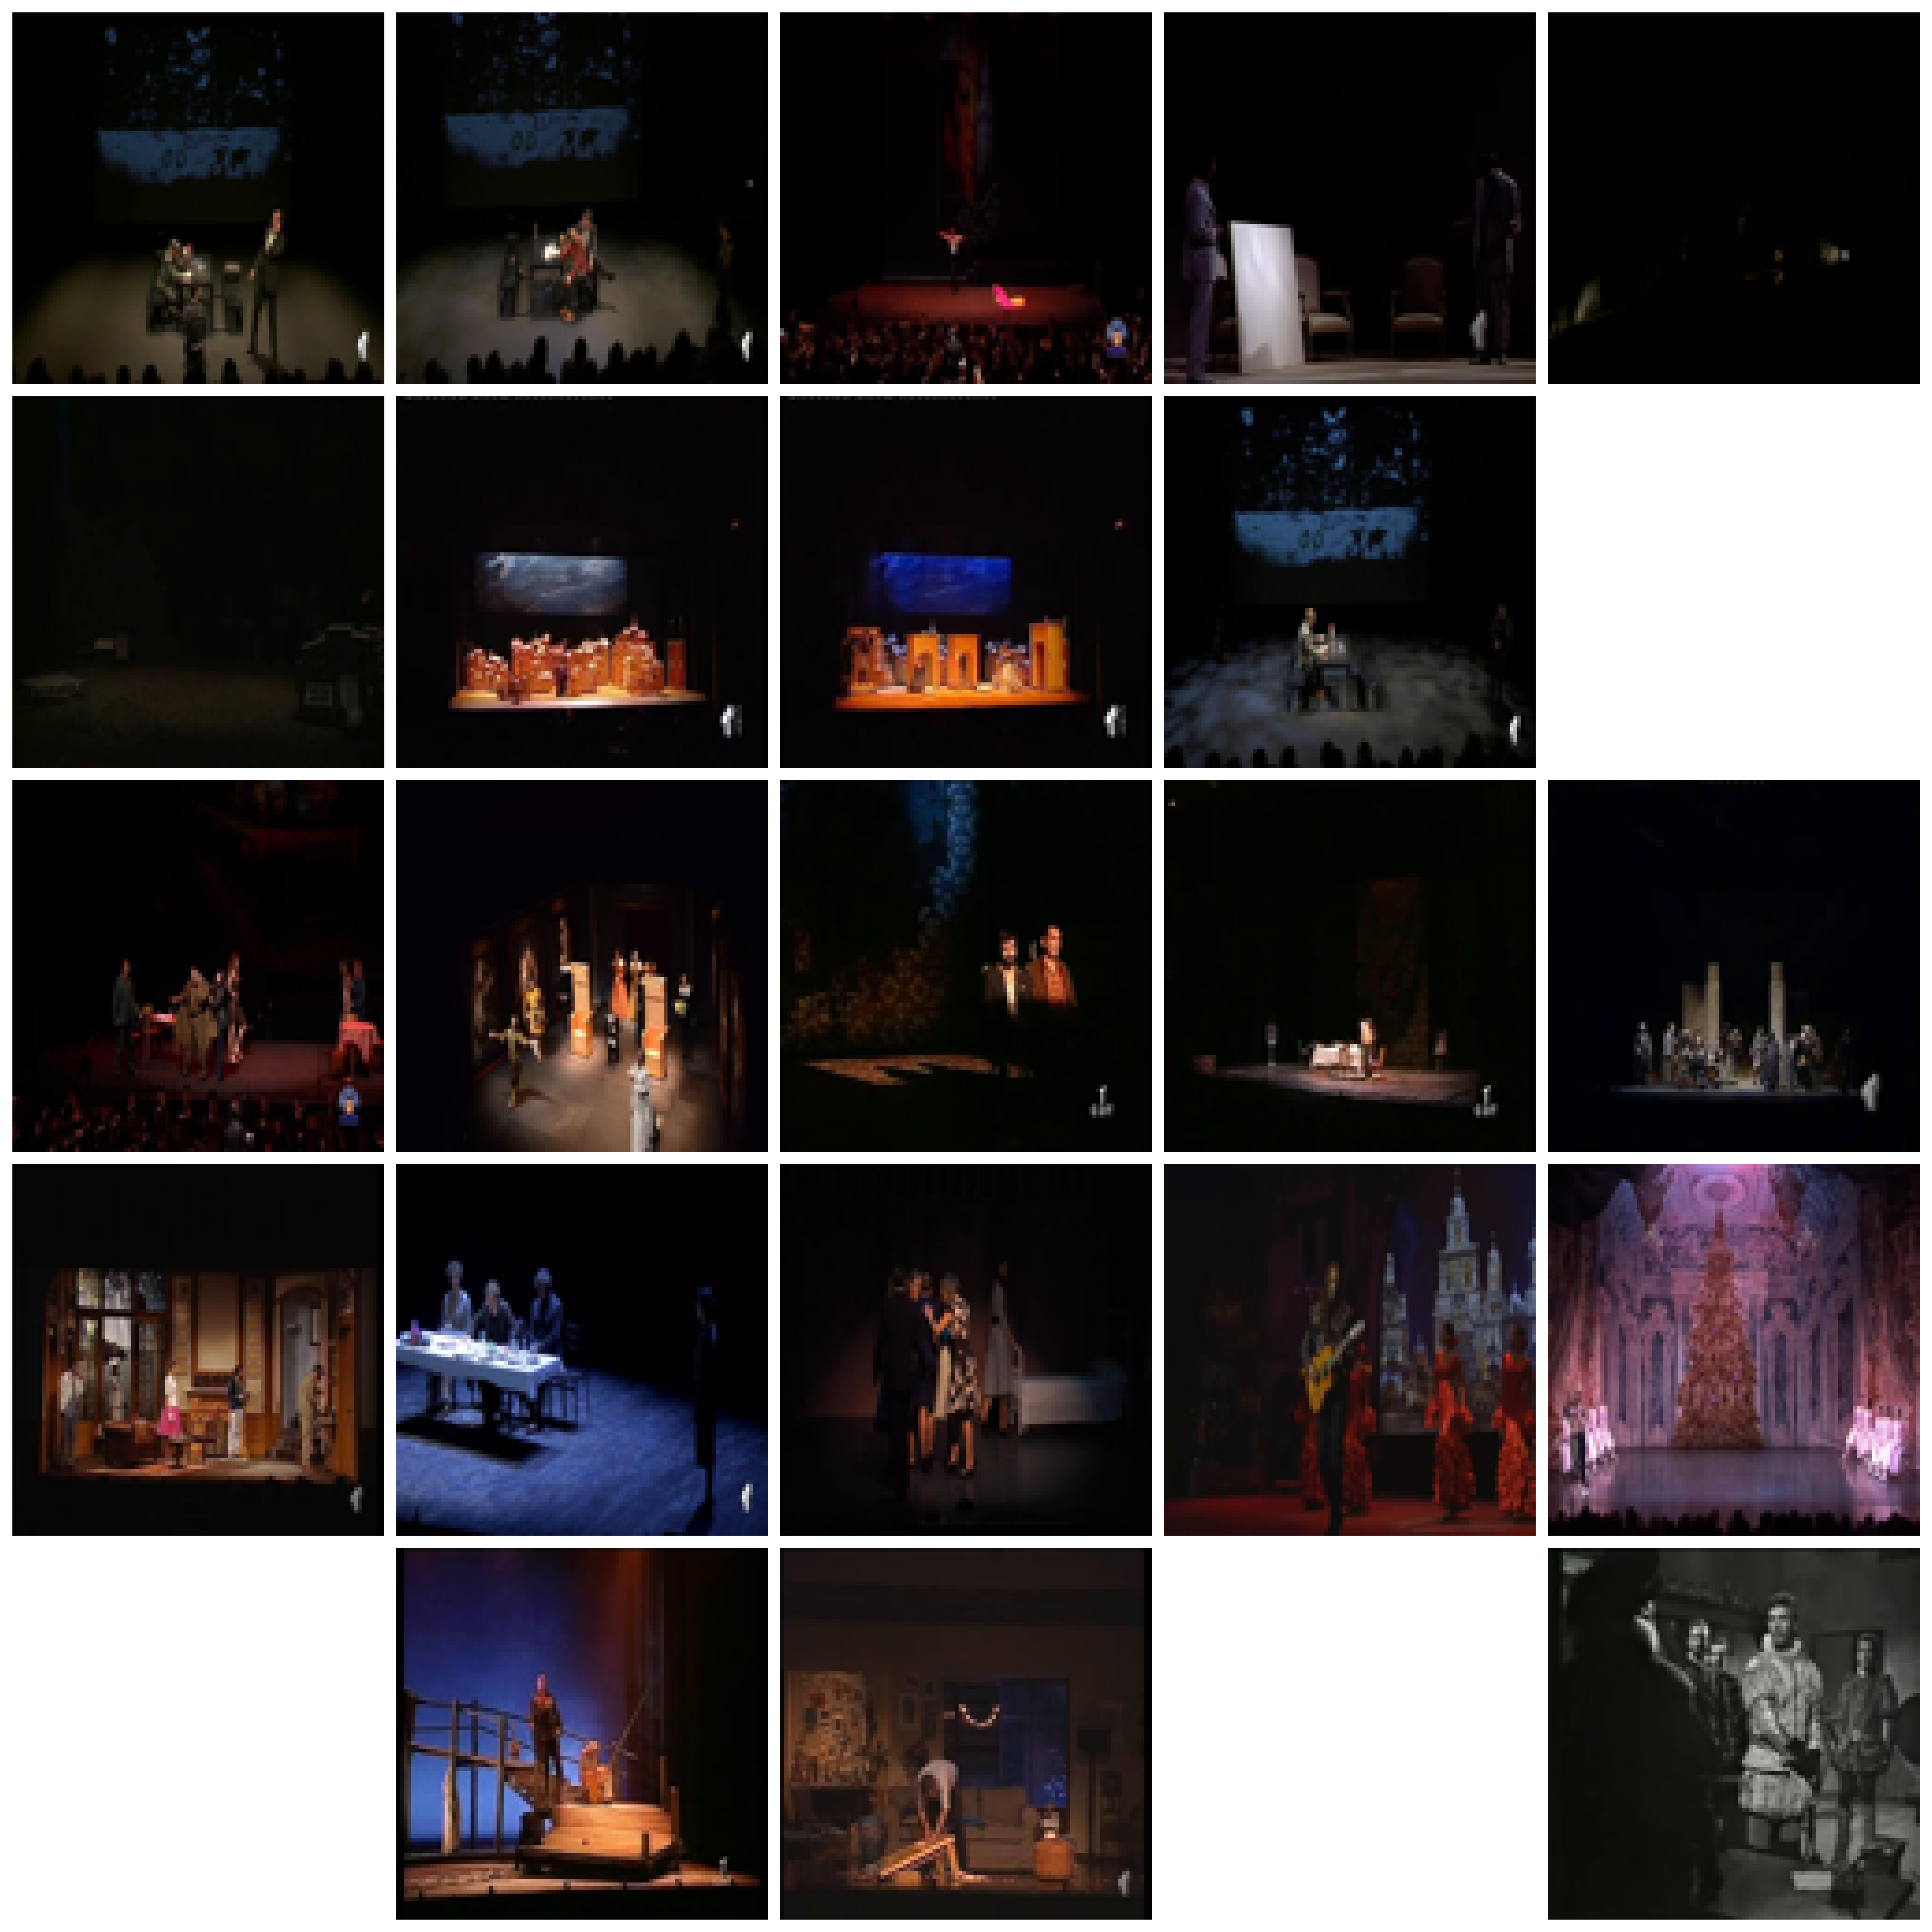

In [23]:
img_arr = []
for image in imageGrid:
    img_arr.append(img_reshape(image))

fig = plt.figure(figsize=(20., 20.), dpi=300)  # 设置图像大小和清晰度

grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 5),  # 创建 5x5 的图像网格
                 axes_pad=0.1,  # 图像之间的间隔
                 )

for ax, im in zip(grid, img_arr):
    ax.imshow(im)
    ax.axis('off')

plt.savefig('theater_image.png')

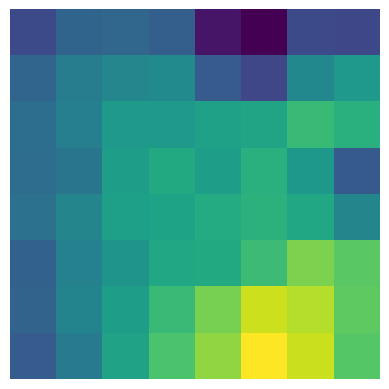

In [24]:
activatedSOM = activate(train_data, SOM, normalise(train_data,featureImagePairs[4]['feature']))
fig = plt.figure()
plt.imshow(activatedSOM)
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 27ms/step


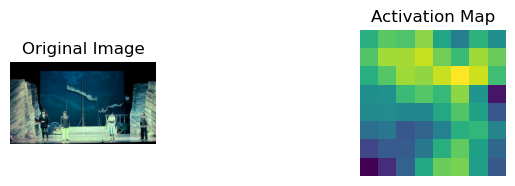

In [26]:
# 读取并预处理图像
selected_image_filename = r"D:\sp\matched frames\TLA_-_Ópera__Marina__Obra_Completa.mp4_38.jpg"
selected_image = Image.open(selected_image_filename)

# 将图像的特征提取出来
selected_image_features = processImage(selected_image_filename, model)

# 使用 activate 函数计算激活区域
activated_SOM = activate(selected_image_features, SOM, normalise(train_data, selected_image_features))

# 显示原始图像
plt.subplot(1, 3, 1)
plt.imshow(selected_image)
plt.title('Original Image')
plt.axis('off')

# 显示激活区域
plt.subplot(1, 3, 3)
plt.imshow(np.expand_dims(activated_SOM, axis=2), cmap='viridis')
plt.title('Activation Map')
plt.axis('off')

plt.show()


# Search and Save function

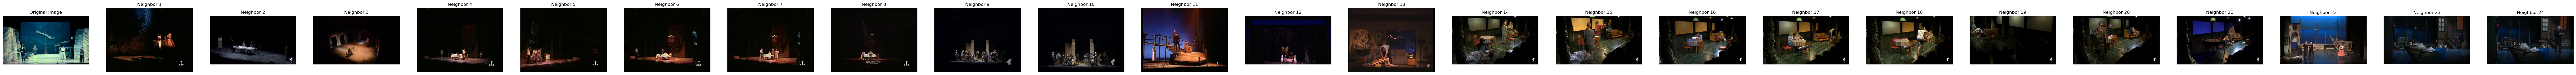

In [34]:
output_directory = r"D:\sp\11"

normalized_selected_features = normalise(train_data, selected_image_features)
bmu_index = find_BMU(SOM, normalized_selected_features)
neighbors = get_neighbors(bmu_index, som_height, som_width, radius=1)  # You can adjust radius as needed

neighbor_images = []
for (i, j) in neighbors:
    if SOMimages[i][j]:
        neighbor_images.extend(SOMimages[i][j])

fig, axes = plt.subplots(1, len(neighbor_images) + 1, figsize=(5 * (len(neighbor_images) + 1), 10))  # Adjusted for larger display
axes[0].imshow(selected_image)
axes[0].set_title('Original Image')
axes[0].axis('off')

original_image_save_path = os.path.join(output_directory, 'Original_Image.jpg')
selected_image.save(original_image_save_path)

for idx, fi in enumerate(neighbor_images):
    img_path = os.path.join(r"D:\sp\matched frames", fi['image'])
    img = Image.open(img_path)
    axes[idx + 1].imshow(img)
    axes[idx + 1].set_title(f"Neighbor {idx + 1}")
    axes[idx + 1].axis('off')
    
    # Save each neighbor image
    neighbor_image_save_path = os.path.join(output_directory, f"Neighbor_{idx + 1}.jpg")
    img.save(neighbor_image_save_path)

plt.show()



# PCA on all cells

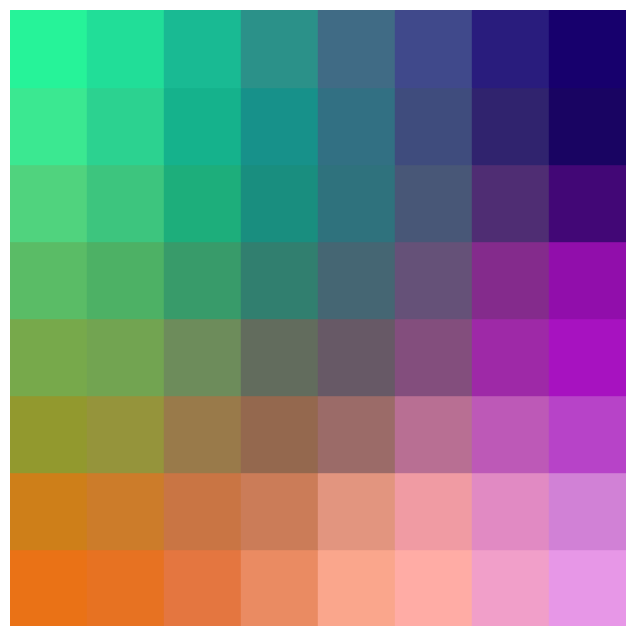

In [29]:
from sklearn.decomposition import PCA
# Assume loaded_text_som_model is your trained SOM model
som_height, som_width, vector_dimension = SOM.shape
num_nodes = som_height * som_width

# Flatten the SOM to apply PCA
flattened_som = SOM.reshape(num_nodes, vector_dimension)

# Apply PCA to reduce dimensions to 3 for RGB visualization
pca = PCA(n_components=3)
colourComponents = pca.fit_transform(flattened_som)

# Normalize PCA components
colourComponents = normalise(colourComponents, colourComponents)

# Convert normalized components to RGB values
rgb_values = (colourComponents * 255).astype(int)

# Prepare a grid for visualization
som_colors = np.zeros((som_height, som_width, 3), dtype=np.uint8)
for i in range(som_height):
    for j in range(som_width):
        node_idx = i * som_width + j
        som_colors[i, j] = rgb_values[node_idx]

# Visualization
fig, ax = plt.subplots(figsize=(som_width, som_height))
for i in range(som_height):
    for j in range(som_width):
        color = som_colors[i, j] / 255.0
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color))

ax.set_xlim(0, som_width)
ax.set_ylim(0, som_height)
ax.set_aspect('equal')
ax.axis('off')
plt.show()

# PCA on entire training

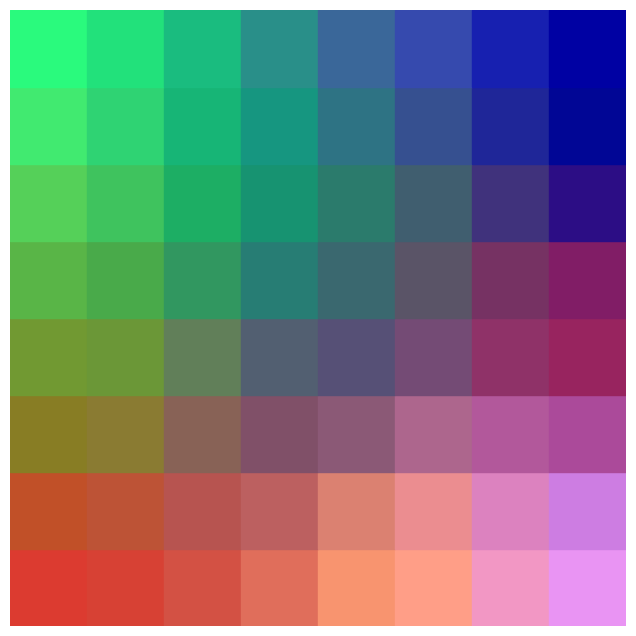

In [31]:
def normalisee(data):
    min_d = np.min(data)
    max_d = np.max(data)
    return (data - min_d) / (max_d - min_d)

# Assume loaded_text_som_model is the trained SOM model
som_height, som_width, vector_dimension = SOM.shape
num_nodes = som_height * som_width

# Assuming sentence_vectors is already defined
pca = PCA(n_components=3)
# Fit PCA on the original high-dimensional sentence vectors
pca.fit(n_train_data)

# Transform the SOM data using the fitted PCA
flattened_som = SOM.reshape(num_nodes, vector_dimension)
colourComponents = pca.transform(flattened_som)

# Normalize the transformed PCA components
normalised_components = normalisee(colourComponents)

# Convert normalized components to RGB values
rgb_values = (normalised_components * 255).astype(np.uint8)

# Prepare a grid for visualization
som_colors = np.zeros((som_height, som_width, 3), dtype=np.uint8)
for i in range(som_height):
    for j in range(som_width):
        node_idx = i * som_width + j
        som_colors[i, j] = rgb_values[node_idx]

# Visualization
fig, ax = plt.subplots(figsize=(som_width, som_height))
for i in range(som_height):
    for j in range(som_width):
        color = som_colors[i, j] / 255.0
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color))

ax.set_xlim(0, som_width)
ax.set_ylim(0, som_height)
ax.set_aspect('equal')
ax.axis('off')
plt.show()
